# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
from imageio import imread
from skimage.transform import resize
import datetime
import os
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [3]:
train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())
batch_size = 32

## Generator - 1
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with some of the parts of the generator function such that you get high accuracy.

In [4]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29]
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(t)/batch_size)
        for batch in range(num_batches):
            batch_data = np.zeros((batch_size,18,100,100,3))
            batch_labels = np.zeros((batch_size,5))
            for folder in range(batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    if image.shape[1] == 160:
                        image = resize(image[:,20:140,:],(100,100)).astype(np.float32)
                    else:
                        image = resize(image,(100,100)).astype(np.float32)

                    batch_data[folder,idx,:,:,0] = (image[:,:,0]) / 255.0  
                    batch_data[folder,idx,:,:,1] = (image[:,:,1]) / 255.0  
                    batch_data[folder,idx,:,:,2] = (image[:,:,2]) / 255.0 
                    
                    batch_data[folder,idx,:,:,0] = image[:,:,0] - 104
                    batch_data[folder,idx,:,:,1] = image[:,:,1] - 117
                    batch_data[folder,idx,:,:,2] = image[:,:,2] - 123
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,18,100,100,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    if image.shape[1] == 160:
                        image = resize(image[:,20:140,:],(100,100)).astype(np.float32)
                    else:
                        image = resize(image,(100,100)).astype(np.float32)

                    batch_data[folder,idx,:,:,0] = (image[:,:,0]) / 255.0  
                    batch_data[folder,idx,:,:,1] = (image[:,:,1]) / 255.0  
                    batch_data[folder,idx,:,:,2] = (image[:,:,2]) / 255.0 

                    batch_data[folder,idx,:,:,0] = image[:,:,0] - 104
                    batch_data[folder,idx,:,:,1] = image[:,:,1] - 117
                    batch_data[folder,idx,:,:,2] = image[:,:,2] - 123

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

In [5]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 30
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 30


## Model with Conv3D and MaxPooling3D


Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D`. Also remember that the last layer is the softmax. Remember that the network is designed in such a way that the model is able to fit in the memory of the webcam.

**Batch size = 32**

**Number of frames = 18**

**Image width = 100**

**Image height = 100**

**Epochs = 30**

**Activation function = relu**

In [6]:
from keras.models import Sequential
from keras.layers import Dense, GRU, Dropout, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers

model = Sequential()
model.add(Conv3D(64, (3,3,3), strides=(1,1,1), padding='same', input_shape=(18,100,100,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,1), strides=(2,2,1)))

model.add(Conv3D(128, (3,3,3), strides=(1,1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

# model.add(Dropout(0.25))

model.add(Conv3D(256, (3,3,3), strides=(1,1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

# model.add(Dropout(0.25))

model.add(Conv3D(256, (3,3,3), strides=(1,1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

2022-10-11 02:09:34.849809: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-10-11 02:09:34.849870: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14803 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:40:00.0, compute capability: 7.5


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [7]:
sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 18, 100, 100, 64)  5248      
                                                                 
 batch_normalization (BatchN  (None, 18, 100, 100, 64)  256      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 18, 100, 100, 64)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 9, 50, 100, 64)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 9, 50, 100, 128)   221312    
                                                                 
 batch_normalization_1 (Batc  (None, 9, 50, 100, 128)  5

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [8]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [9]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', epsilon=0.0001, cooldown=0, min_lr=0.00001)
callbacks_list = [checkpoint, LR]

In [10]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [11]:
conv3d = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 32
Epoch 1/30


2022-10-11 02:09:40.240139: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


21/21 [==============================] - ETA: 0s - loss: 3.0594 - categorical_accuracy: 0.3288Source path =  /home/datasets/Project_data/val ; batch size = 32

Epoch 00001: saving model to model_init_2022-10-1102_09_34.032725/model-00001-3.05943-0.32881-6.52299-0.23000.h5
21/21 [==============================] - 107s 5s/step - loss: 3.0594 - categorical_accuracy: 0.3288 - val_loss: 6.5230 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 1.4660 - categorical_accuracy: 0.4706
Epoch 00002: saving model to model_init_2022-10-1102_09_34.032725/model-00002-1.46597-0.47059-3.86403-0.19000.h5
21/21 [==============================] - 99s 5s/step - loss: 1.4660 - categorical_accuracy: 0.4706 - val_loss: 3.8640 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 3/30
16/21 [=====================>........] - ETA: 18s - loss: 1.2233 - categorical_accuracy: 0.5098
Epoch 00003: saving model to model_init_2022-10-1102_09_34.032725/mo

In [12]:
model.save("GestureRecognition.h5")

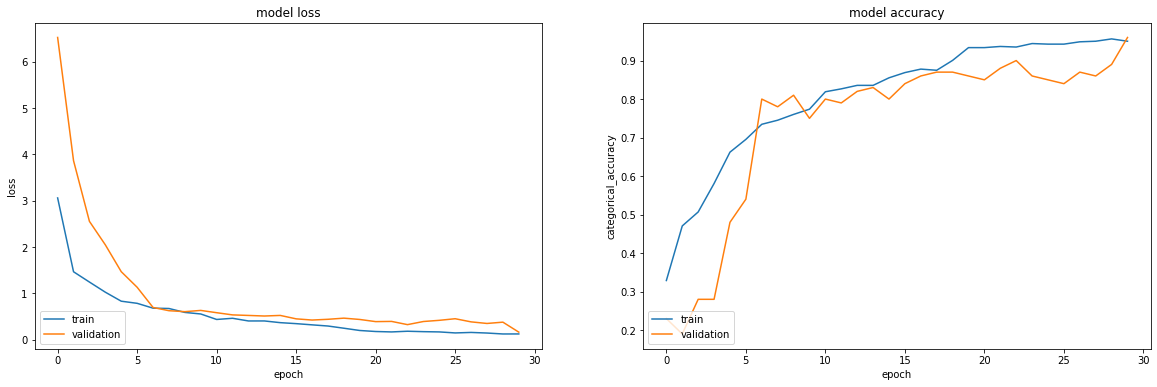

In [13]:
plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(conv3d.history['loss'])
ax1 = plt.plot(conv3d.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(conv3d.history['categorical_accuracy'])
ax2 = plt.plot(conv3d.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')

## Model 2

In [ ]:
train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())
batch_size = 32

## Generator - 2
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with some of the parts of the generator function such that you get high accuracy.

In [ ]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28]
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(t)/batch_size)
        for batch in range(num_batches):
            batch_data = np.zeros((batch_size,15,120,120,3))
            batch_labels = np.zeros((batch_size,5))
            for folder in range(batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    if image.shape[1] == 160:
                        image = resize(image[:,20:140,:],(120,120)).astype(np.float32)
                    else:
                        image = resize(image,(120,120)).astype(np.float32)
                    
                    batch_data[folder,idx,:,:,0] = image[:,:,0] - 104
                    batch_data[folder,idx,:,:,1] = image[:,:,1] - 117
                    batch_data[folder,idx,:,:,2] = image[:,:,2] - 123
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,15,120,120,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    if image.shape[1] == 160:
                        image = resize(image[:,20:140,:],(120,120)).astype(np.float32)
                    else:
                        image = resize(image,(120,120)).astype(np.float32)

                    batch_data[folder,idx,:,:,0] = image[:,:,0] - 104
                    batch_data[folder,idx,:,:,1] = image[:,:,1] - 117
                    batch_data[folder,idx,:,:,2] = image[:,:,2] - 123

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

In [ ]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 40
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 40


## Model with VGG16, GRU and Time Distributed Layer

Here you make the model using different functionalities that Keras provides. You might want to use `TimeDistributed`, `GRU` and other RNN structures after doing transfer learning. Also remember that the last layer is the softmax. Remember that the network is designed in such a way that the model is able to fit in the memory of the webcam.

**Batch size = 32**

**Number of frames = 15**

**Image width = 120**

**Image height = 120**

**Epochs = 40**

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Dropout, Flatten, TimeDistributed
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers
from keras.applications.vgg16 import VGG16
    
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(120,120,3))
x = base_model.output
x = Flatten()(x)

features = Dense(64, activation='relu')(x)
conv_model = Model(inputs=base_model.input, outputs=features)
    
for layer in base_model.layers:
    layer.trainable = False
        
model = Sequential()
model.add(TimeDistributed(conv_model, input_shape=(15,120,120,3)))
model.add(GRU(32, return_sequences=True))
model.add(GRU(16))
model.add(Dropout(0.5))
model.add(Dense(8, activation='relu'))
model.add(Dense(5, activation='softmax'))

58900480/58889256 [==============================] - 1s 0us/step


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [ ]:
sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 15, 64)           15009664  
 ibuted)                                                         
                                                                 
 gru (GRU)                   (None, 15, 32)            9408      
                                                                 
 gru_1 (GRU)                 (None, 16)                2400      
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 8)                 136       
                                                                 
 dense_4 (Dense)             (None, 5)                 45        
                                                      

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
model_name = 'model_init_conv_lstm' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', epsilon=0.0001, cooldown=0, min_lr=0.00001)
callbacks_list = [checkpoint, LR]

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
vggmodel = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 32
Epoch 1/40
21/21 [==============================] - ETA: 0s - loss: 1.7211 - categorical_accuracy: 0.2066Source path =  /home/datasets/Project_data/val ; batch size = 32

Epoch 00001: saving model to model_init_conv_lstm_2022-10-1102_57_31.083168/model-00001-1.72114-0.20664-1.61259-0.25000.h5
21/21 [==============================] - 88s 4s/step - loss: 1.7211 - categorical_accuracy: 0.2066 - val_loss: 1.6126 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 2/40
21/21 [==============================] - ETA: 0s - loss: 1.6363 - categorical_accuracy: 0.2308
Epoch 00002: saving model to model_init_conv_lstm_2022-10-1102_57_31.083168/model-00002-1.63633-0.23077-1.52208-0.24000.h5
21/21 [==============================] - 82s 4s/step - loss: 1.6363 - categorical_accuracy: 0.2308 - val_loss: 1.5221 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 3/40
21/21 [==============================] - ETA: 0s - loss: 1.5835 - c

In [ ]:
model.save("GestureRecognition2.h5")

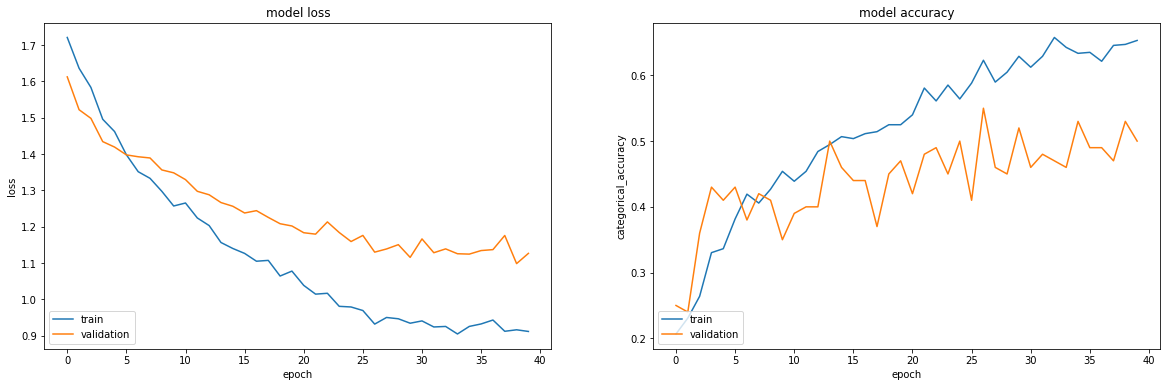

In [ ]:
plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(vggmodel.history['loss'])
ax1 = plt.plot(vggmodel.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(vggmodel.history['categorical_accuracy'])
ax2 = plt.plot(vggmodel.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')

## Model 3

In [ ]:
train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())
batch_size = 32

In [ ]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 30
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 30


## Model with Conv2D + LSTM layers

**Batch size = 32**

**Number of frames = 15**

**Image width = 120**

**Image height = 120**

**Epochs = 30**

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras import backend
from tensorflow.python.keras.applications import imagenet_utils
from keras.layers.convolutional import Conv2D, Conv3D
from keras.layers import GlobalAveragePooling2D,ConvLSTM2D

model = Sequential()
model.add(TimeDistributed(
    Conv2D(8, (3,3), activation='relu'), input_shape=(15,120,120,3))
)
model.add(BatchNormalization())
model.add(TimeDistributed(
    Conv2D(16, (3,3), activation='relu'))
)
model.add(BatchNormalization())
model.add(
    ConvLSTM2D(8, kernel_size = 3, return_sequences=False)
)
model.add(BatchNormalization())
model.add(TimeDistributed(
    Dense(64, activation='relu'))
)
model.add(BatchNormalization())
model.add(GlobalAveragePooling2D())
model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax'))

In [ ]:
model.compile(optimizer = Adam(), loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_1 (TimeDis  (None, 15, 118, 118, 8)  224       
 tributed)                                                       
                                                                 
 batch_normalization_4 (Batc  (None, 15, 118, 118, 8)  32        
 hNormalization)                                                 
                                                                 
 time_distributed_2 (TimeDis  (None, 15, 116, 116, 16)  1168     
 tributed)                                                       
                                                                 
 batch_normalization_5 (Batc  (None, 15, 116, 116, 16)  64       
 hNormalization)                                                 
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, 114, 114, 8)      

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', epsilon=0.0001, cooldown=0, min_lr=0.00001)
callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
lstm2d = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 32
Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 1.5171 - categorical_accuracy: 0.2971Source path =  /home/datasets/Project_data/val ; batch size = 32

Epoch 00001: saving model to model_init_2022-10-1103_52_05.837604/model-00001-1.51707-0.29713-1.59017-0.23000.h5
21/21 [==============================] - 82s 4s/step - loss: 1.5171 - categorical_accuracy: 0.2971 - val_loss: 1.5902 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 1.3352 - categorical_accuracy: 0.4781
Epoch 00002: saving model to model_init_2022-10-1103_52_05.837604/model-00002-1.33522-0.47813-1.56478-0.24000.h5
21/21 [==============================] - 79s 4s/step - loss: 1.3352 - categorical_accuracy: 0.4781 - val_loss: 1.5648 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 3/30
21/21 [==============================] - ETA: 0s - loss: 1.1936 - categorical_accuracy:

In [ ]:
model.save("GestureRecognition3.h5")

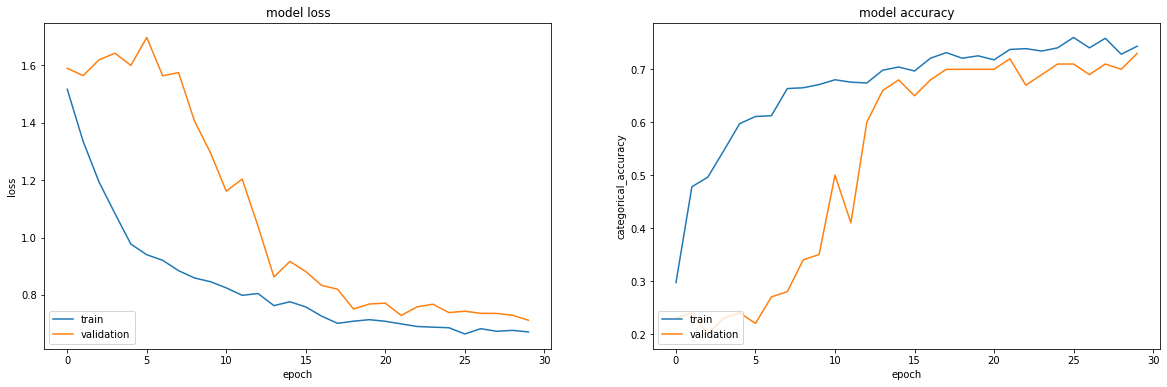

In [ ]:
plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(lstm2d.history['loss'])
ax1 = plt.plot(lstm2d.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(lstm2d.history['categorical_accuracy'])
ax2 = plt.plot(lstm2d.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')

## Model 4

In [ ]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 15
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 15


### Model with Transfer Learning using EfficientNetB0 with GRU layers

**Batch size = 32**

**Number of frames = 15**

**Image width = 120**

**Image height = 120**

**Epochs = 20**

In [ ]:
from tensorflow.keras.applications import EfficientNetB0

base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(120,120,3))

x = base_model.output
x = GlobalAveragePooling2D()(x)

base_model = Model(inputs=base_model.input, outputs=x)

model = Sequential()

model.add(TimeDistributed(base_model, input_shape=base_model.input_shape))
model.add(TimeDistributed(Flatten(input_shape=base_model.input_shape[1:])))
model.add(GRU(256, activation='relu', dropout=0.5))
model.add(Dense(5, activation = 'softmax'))

16719872/16705208 [==============================] - 1s 0us/step


In [ ]:
model.compile(optimizer = Adam(), loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_4 (TimeDis  (None, None, 1280)       4049571   
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, None, 1280)       0         
 tributed)                                                       
                                                                 
 gru_2 (GRU)                 (None, 256)               1181184   
                                                                 
 dense_8 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 5,232,040
Trainable params: 5,190,017
Non-trainable params: 42,023
_________________________________________________________________
None


In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', epsilon=0.0001, cooldown=0, min_lr=0.00001)
callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
effnet = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 32
Epoch 1/15
21/21 [==============================] - ETA: 0s - loss: 0.8504 - categorical_accuracy: 0.6516Source path =  /home/datasets/Project_data/val ; batch size = 32

Epoch 00001: saving model to model_init_2022-10-1104_32_27.130700/model-00001-0.85037-0.65158-0.84681-0.74000.h5
21/21 [==============================] - 94s 4s/step - loss: 0.8504 - categorical_accuracy: 0.6516 - val_loss: 0.8468 - val_categorical_accuracy: 0.7400 - lr: 0.0010
Epoch 2/15
21/21 [==============================] - ETA: 0s - loss: 0.1792 - categorical_accuracy: 0.9427
Epoch 00002: saving model to model_init_2022-10-1104_32_27.130700/model-00002-0.17919-0.94268-0.88757-0.77000.h5
21/21 [==============================] - 80s 4s/step - loss: 0.1792 - categorical_accuracy: 0.9427 - val_loss: 0.8876 - val_categorical_accuracy: 0.7700 - lr: 0.0010
Epoch 3/15
21/21 [==============================] - ETA: 0s - loss: 0.1159 - categorical_accuracy:

In [ ]:
model.save("GestureRecognition4.h5")

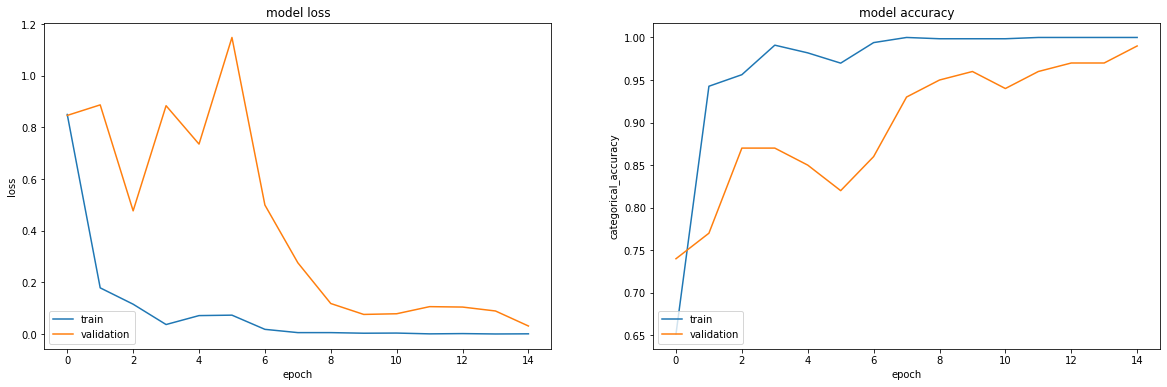

In [ ]:
plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(effnet.history['loss'])
ax1 = plt.plot(effnet.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(effnet.history['categorical_accuracy'])
ax2 = plt.plot(effnet.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')

## Model 5

In [3]:
train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())
batch_size = 32

## Generator - 3
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with some of the parts of the generator function such that you get high accuracy.

In [4]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29]
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(t)/batch_size)
        for batch in range(num_batches):
            batch_data = np.zeros((batch_size,18,100,100,3))
            batch_labels = np.zeros((batch_size,5))
            for folder in range(batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    if image.shape[1] == 160:
                        image = resize(image[:,20:140,:],(100,100)).astype(np.float32)
                    else:
                        image = resize(image,(100,100)).astype(np.float32)

                    batch_data[folder,idx,:,:,0] = (image[:,:,0]) / 255.0  
                    batch_data[folder,idx,:,:,1] = (image[:,:,1]) / 255.0  
                    batch_data[folder,idx,:,:,2] = (image[:,:,2]) / 255.0 
                    
                    batch_data[folder,idx,:,:,0] = image[:,:,0] - 104
                    batch_data[folder,idx,:,:,1] = image[:,:,1] - 117
                    batch_data[folder,idx,:,:,2] = image[:,:,2] - 123
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,18,100,100,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    if image.shape[1] == 160:
                        image = resize(image[:,20:140,:],(100,100)).astype(np.float32)
                    else:
                        image = resize(image,(100,100)).astype(np.float32)

                    batch_data[folder,idx,:,:,0] = (image[:,:,0]) / 255.0  
                    batch_data[folder,idx,:,:,1] = (image[:,:,1]) / 255.0  
                    batch_data[folder,idx,:,:,2] = (image[:,:,2]) / 255.0 

                    batch_data[folder,idx,:,:,0] = image[:,:,0] - 104
                    batch_data[folder,idx,:,:,1] = image[:,:,1] - 117
                    batch_data[folder,idx,:,:,2] = image[:,:,2] - 123

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

In [5]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 30
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 30


### Model with Transfer Learning using Conv3D with MaxPooling3D and reduced parameters

**Batch size = 32**

**Number of frames = 18**

**Image width = 100**

**Image height = 100**

**Epochs = 30**

In [6]:
from keras.models import Sequential
from keras.layers import Dense, GRU, Dropout, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers

model = Sequential()
model.add(Conv3D(64, (3,3,3), strides=(1,1,1), padding='same', input_shape=(18,100,100,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,1), strides=(2,2,1)))

model.add(Conv3D(256, (3,3,3), strides=(1,1,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))


model.add(Conv3D(128, (3,3,3), strides=(1,1,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(5, activation='softmax'))

2022-10-11 18:29:30.633219: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-10-11 18:29:30.633278: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22852 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:1c:00.0, compute capability: 7.5


In [7]:
sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 18, 100, 100, 64)  5248      
                                                                 
 batch_normalization (BatchN  (None, 18, 100, 100, 64)  256      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 18, 100, 100, 64)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 9, 50, 100, 64)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 9, 50, 100, 256)   442624    
                                                                 
 activation_1 (Activation)   (None, 9, 50, 100, 256)   0

In [8]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [9]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', epsilon=0.0001, cooldown=0, min_lr=0.00001)
callbacks_list = [checkpoint, LR]

In [10]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [11]:
conv3d_final = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 32
Epoch 1/30


2022-10-11 18:29:43.989338: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


21/21 [==============================] - ETA: 0s - loss: 1.6665 - categorical_accuracy: 0.2624Source path =  /home/datasets/Project_data/val ; batch size = 32

Epoch 00001: saving model to model_init_2022-10-1118_28_06.777232/model-00001-1.66652-0.26244-1.42095-0.45000.h5
21/21 [==============================] - 105s 5s/step - loss: 1.6665 - categorical_accuracy: 0.2624 - val_loss: 1.4209 - val_categorical_accuracy: 0.4500 - lr: 0.0010
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 1.4706 - categorical_accuracy: 0.3605
Epoch 00002: saving model to model_init_2022-10-1118_28_06.777232/model-00002-1.47059-0.36048-1.38104-0.52000.h5
21/21 [==============================] - 100s 5s/step - loss: 1.4706 - categorical_accuracy: 0.3605 - val_loss: 1.3810 - val_categorical_accuracy: 0.5200 - lr: 0.0010
Epoch 3/30
21/21 [==============================] - ETA: 0s - loss: 1.3124 - categorical_accuracy: 0.4465
Epoch 00003: saving model to model_init_2022-10-1118_28_06.777232/mo

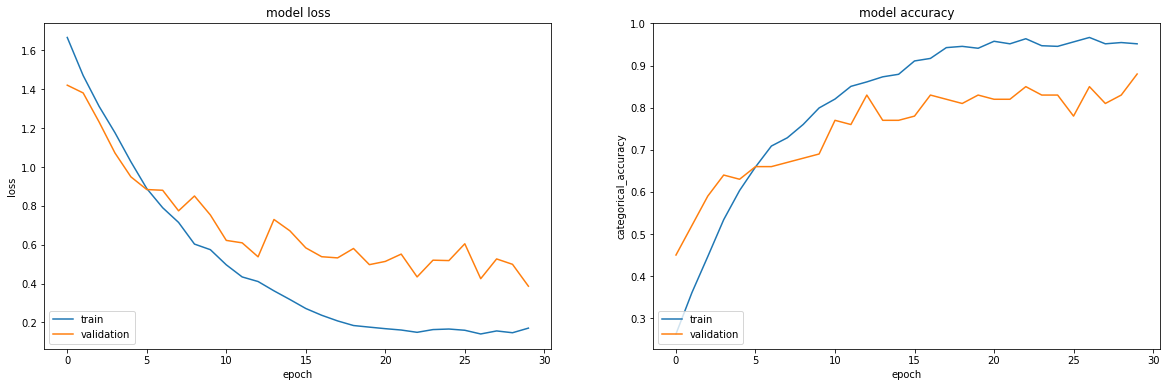

In [13]:
plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(conv3d_final.history['loss'])
ax1 = plt.plot(conv3d_final.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(conv3d_final.history['categorical_accuracy'])
ax2 = plt.plot(conv3d_final.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')